# BIAS ANALYSIS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
from IPython.display import display, clear_output

In [2]:
periods = ['Q1', 'Q2', 'Q3', 'A1', 'A2']

In [35]:
data = {}
for period in periods:
    data[period] = pd.read_csv(f"results/{period}_rf.csv")

NOTE: 

We trim the data at the 1% level each period before taking the average. divide annual by 4

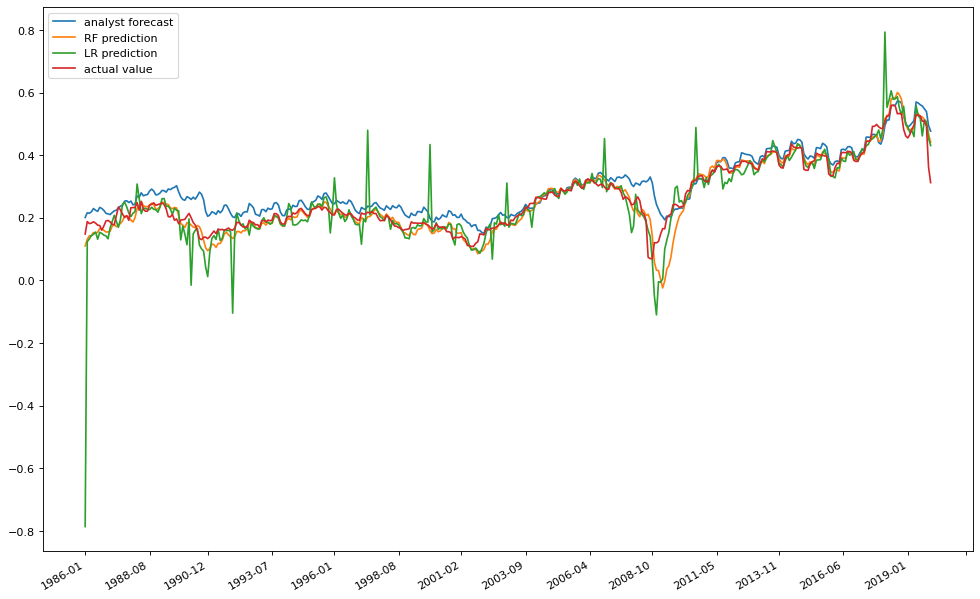

In [4]:
plt.figure(figsize=(15, 10), dpi=80)
df = data['Q2']
plt.plot(df.Date.unique().astype(str), df.groupby(['Date']).meanest.apply(lambda x: stats.trim_mean(x, 0.01)), label='analyst forecast');
plt.plot(df.Date.unique().astype(str), df.groupby(['Date']).predicted_adj_actual.apply(lambda x: stats.trim_mean(x, 0.01)), label='RF prediction');
plt.plot(df.Date.unique().astype(str), df.groupby(['Date']).predicted_adj_actual_LR.apply(lambda x: stats.trim_mean(x, 0.01)), label='LR prediction');
plt.plot(df.Date.unique().astype(str), df.groupby(['Date']).adj_actual.apply(lambda x: stats.trim_mean(x, 0.01)), label='actual value');
locator = mdate.MonthLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gcf().autofmt_xdate()
plt.legend()   

Text(0.5, 1.0, 'Average bias of analysts earings expectations relative to machine learning forecasts')

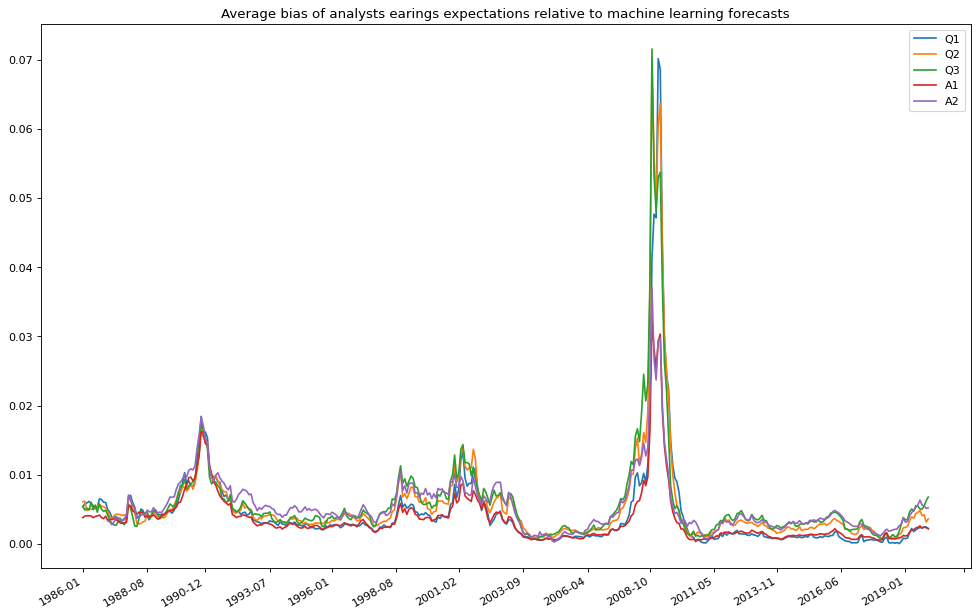

In [5]:
plt.figure(figsize=(15, 10), dpi=80)
for period, df_real in data.items():
    df = df_real.copy()
    if period == 'A2' or period=='A1':
        df.bias_AF_ML = df.bias_AF_ML/4
    plt.plot(df.Date.unique().astype(str), df.groupby(['Date']).bias_AF_ML.apply(lambda x: stats.trim_mean(x, 0.01)), label=period);
locator = mdate.MonthLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gcf().autofmt_xdate()
plt.legend()   
plt.title('Average bias of analysts earings expectations relative to machine learning forecasts') 

Text(0.5, 1.0, 'Average realized bias of analysts earings expectations')

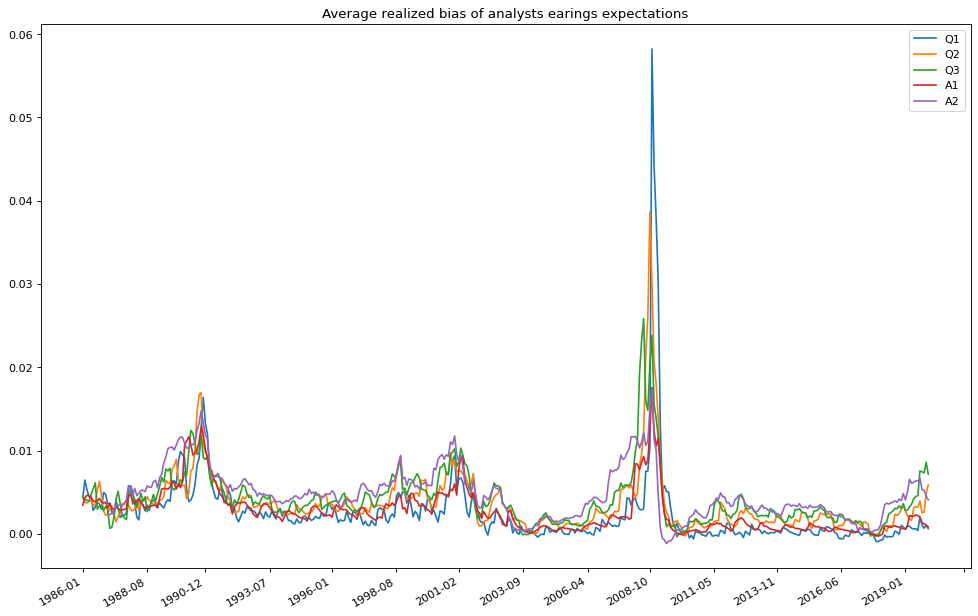

In [6]:
plt.figure(figsize=(15, 10), dpi=80)
for period, df in data.items():
    df['bias_analyst_actual'] = (df.meanest - df.adj_actual) / df.price
    if period == 'A2' or period=='A1':
        df.bias_analyst_actual = df.bias_analyst_actual / 4
    plt.plot(df.Date.unique().astype(str), df.groupby(['Date']).bias_analyst_actual.apply(lambda x: stats.trim_mean(x, 0.01)), label=period);
locator = mdate.MonthLocator()
plt.gca().xaxis.set_major_locator(locator)
plt.gcf().autofmt_xdate()
plt.legend()  
plt.title('Average realized bias of analysts earings expectations') 


## Bias wrt to machine learning model

In [7]:
def compute_bias_results (period, model):
    if model == 'RF':
        prediction='predicted_adj_actual'
    elif model=='LR':
        prediction='predicted_adj_actual_LR'

    df = data[period]
    ML = df[prediction].mean()
    AF = df.meanest.mean()
    AE = df.adj_actual.mean()
    ML_AE = (df[prediction] - df.adj_actual).mean()
    AF_AE = (df.meanest - df.adj_actual).mean()
    ML_AE2 = ((df[prediction] - df.adj_actual)**2).mean()
    AF_AE2 = ((df.meanest - df.adj_actual)**2).mean()
    bias = ((df.meanest - df[prediction]) / df.price).mean()

    return {'value': period, model: round(ML, 3), 'AF': round(AF, 3), 'AE':round(AE, 3),f'({model}-AE)':round(ML_AE, 3), '(AF-AE)':round(AF_AE, 3),
    f'({model}-AE)^2':round(ML_AE2, 3), '(AF-AE)^2': round(AF_AE2, 3), f'(AF-{model})/P':round(bias, 3), 'N':len(df) }
    

In [8]:
# Create an empty dictionary to store DataFrames
results_RF = []
results_LR = []

for period in periods:
    results_RF.append(compute_bias_results(period, 'RF'))
    results_LR.append(compute_bias_results(period, 'LR'))

In [9]:
display(pd.DataFrame(results_RF).set_index('value').rename_axis(None))

,RF,AF,AE,(RF-AE),(AF-AE),(RF-AE)^2,(AF-AE)^2,(AF-RF)/P,N
Q1,0.256,0.274,0.259,-0.003,0.014,0.106,0.089,0.005,888694
Q2,0.274,0.313,0.276,-0.002,0.037,0.129,0.119,0.006,814051
Q3,0.295,0.346,0.295,0.000,0.051,0.157,0.156,0.007,750322
A1,0.981,1.064,0.983,-0.003,0.080,0.447,0.451,0.016,913051
A2,1.154,1.377,1.147,0.007,0.230,1.112,1.422,0.024,775161


In [10]:
display(pd.DataFrame(results_LR).set_index('value').rename_axis(None))

,LR,AF,AE,(LR-AE),(AF-AE),(LR-AE)^2,(AF-AE)^2,(AF-LR)/P,N
Q1,-351104.642,0.274,0.259,-351104.901,0.014,1.853272e+17,0.089,92595.406,888694
Q2,-674277.391,0.313,0.276,-674277.667,0.037,5.097627e+17,0.119,168053.654,814051
Q3,-1043728.056,0.346,0.295,-1043728.351,0.051,4.895676e+17,0.156,73814.313,750322
A1,-2889887.480,1.064,0.983,-2889888.463,0.080,9.274005e+18,0.451,178463.248,913051
A2,9922116.386,1.377,1.147,9922115.239,0.230,7.207156e+19,1.422,-661337.156,775161


# Explaining bias
## Bias and FFI49

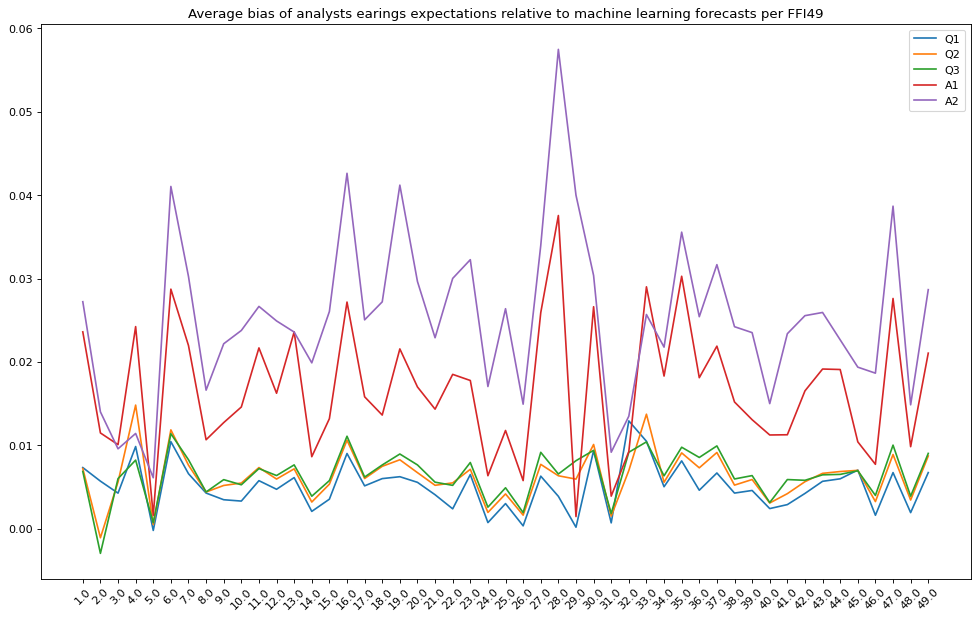

In [11]:
plt.figure(figsize=(15, 9), dpi=80)
for period in periods: 
    df = data[period].copy()
    df.sort_values('ffi49', inplace=True)
    #if period == 'A2' or period=='A1':
       # df.bias_AF_ML = df.bias_AF_ML / 4
    plt.plot(df.ffi49.unique().astype(str), df.groupby(['ffi49']).bias_AF_ML.apply(lambda x: x.mean()), label=period);  #stats.trim_mean(x, 0.01)
    plt.xticks(rotation=45)
    plt.legend()   
    plt.title('Average bias of analysts earings expectations relative to machine learning forecasts per FFI49') 

## Bias and Number of Anlysts

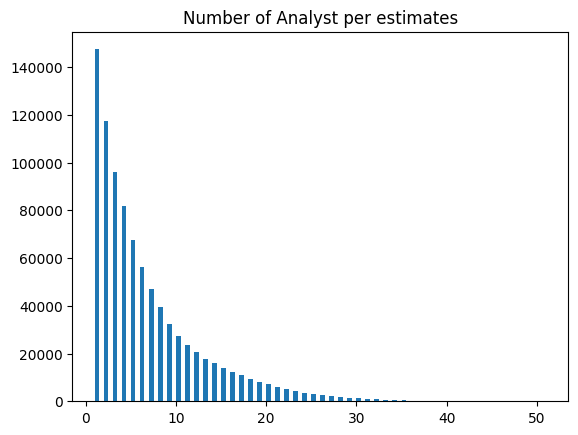

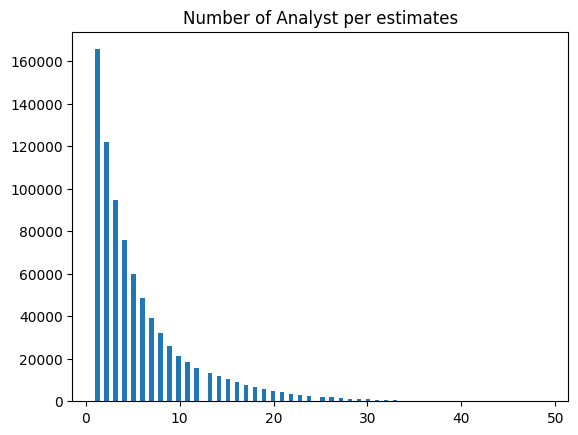

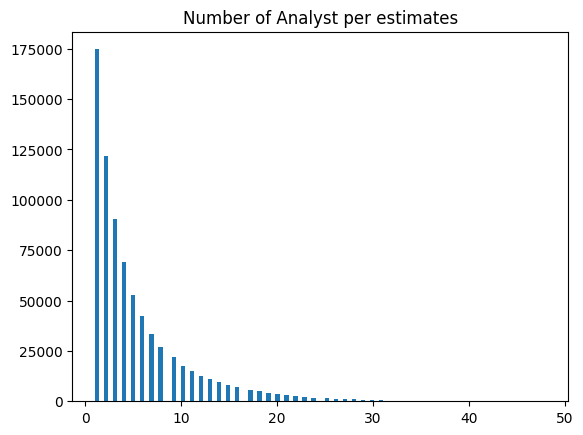

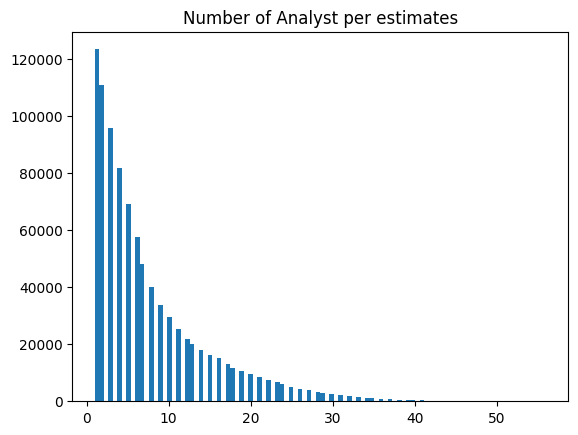

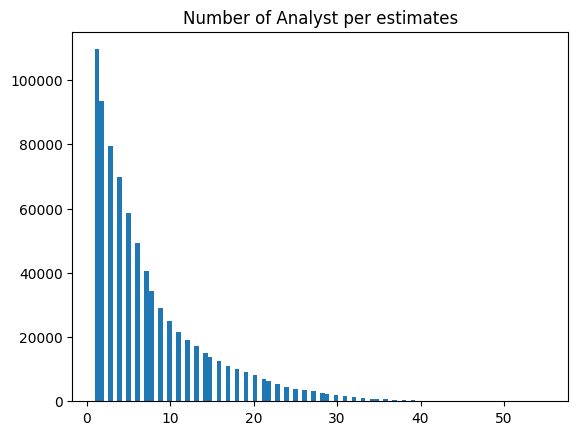

In [12]:
for period in periods: 
    plt.figure()
    df = data[period].copy()
    plt.hist(df.numest, bins=100)
    plt.title('Number of Analyst per estimates') 

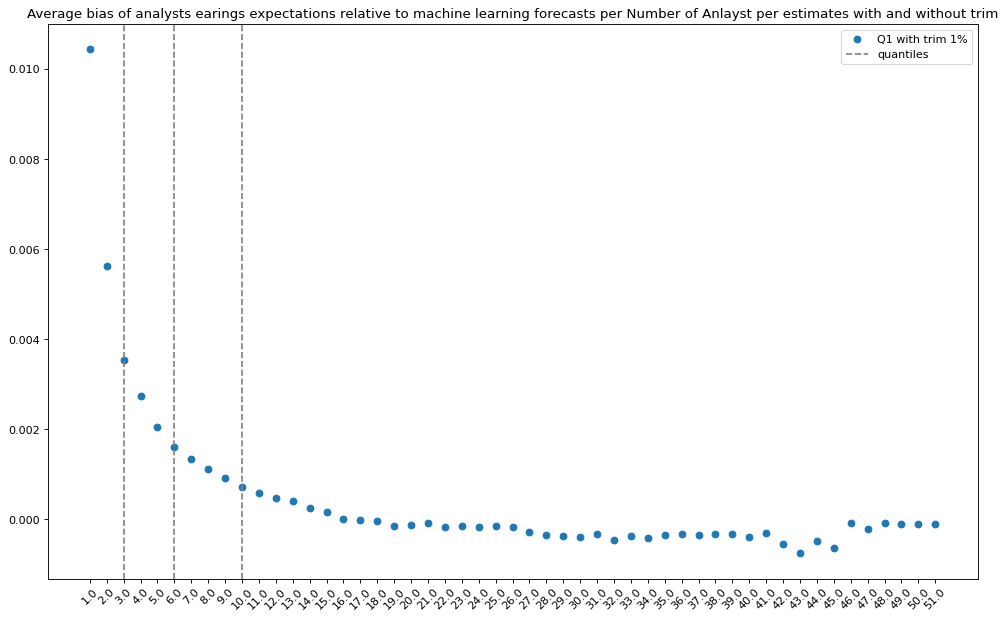

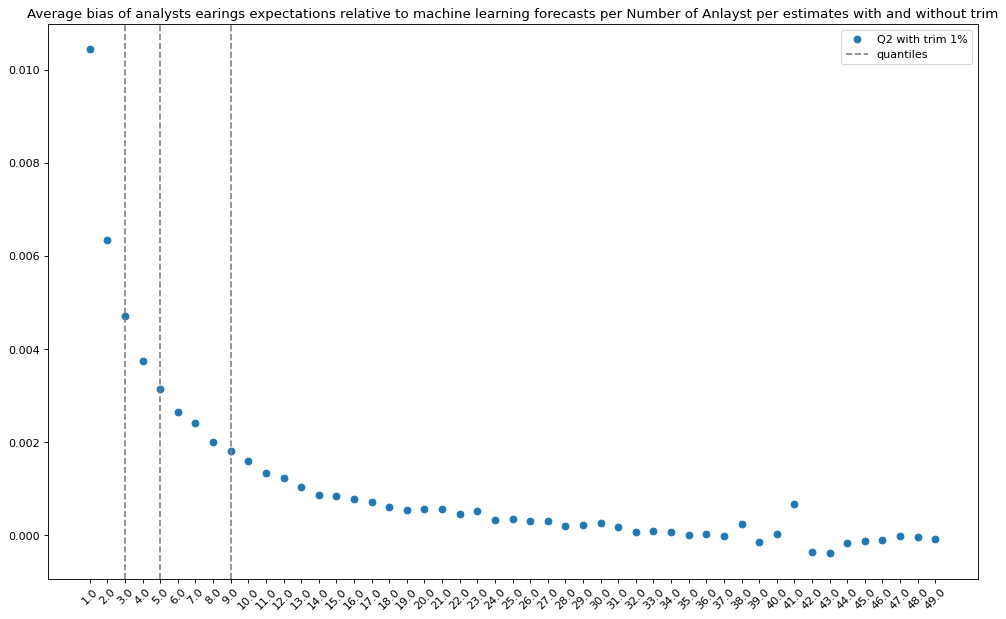

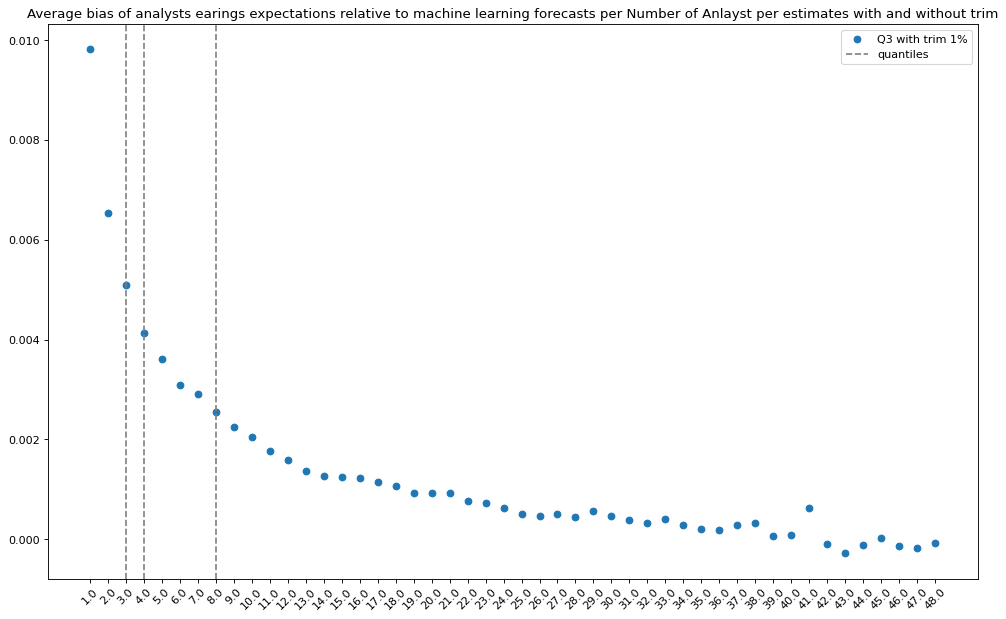

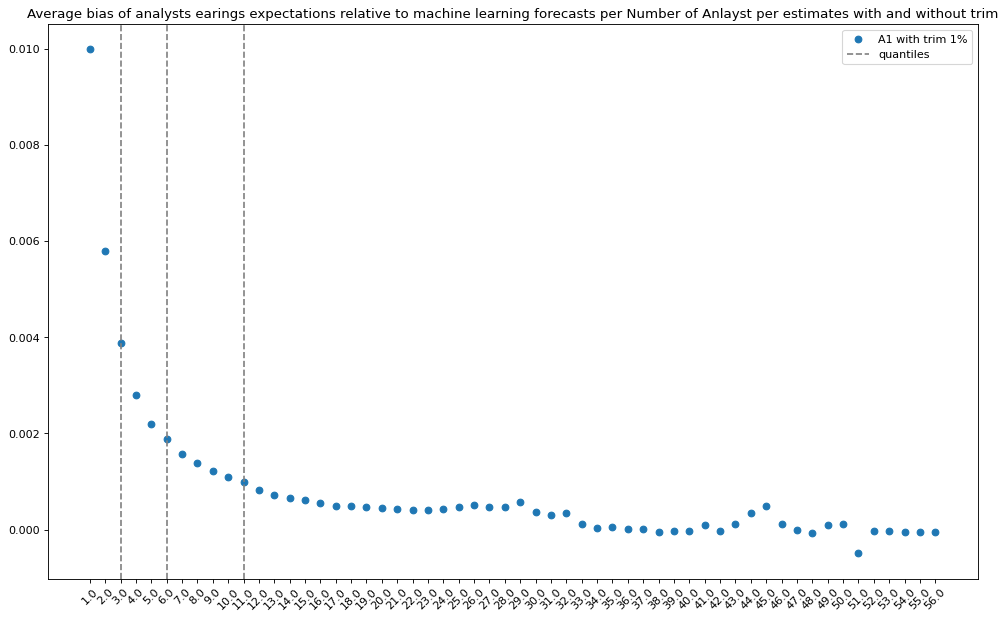

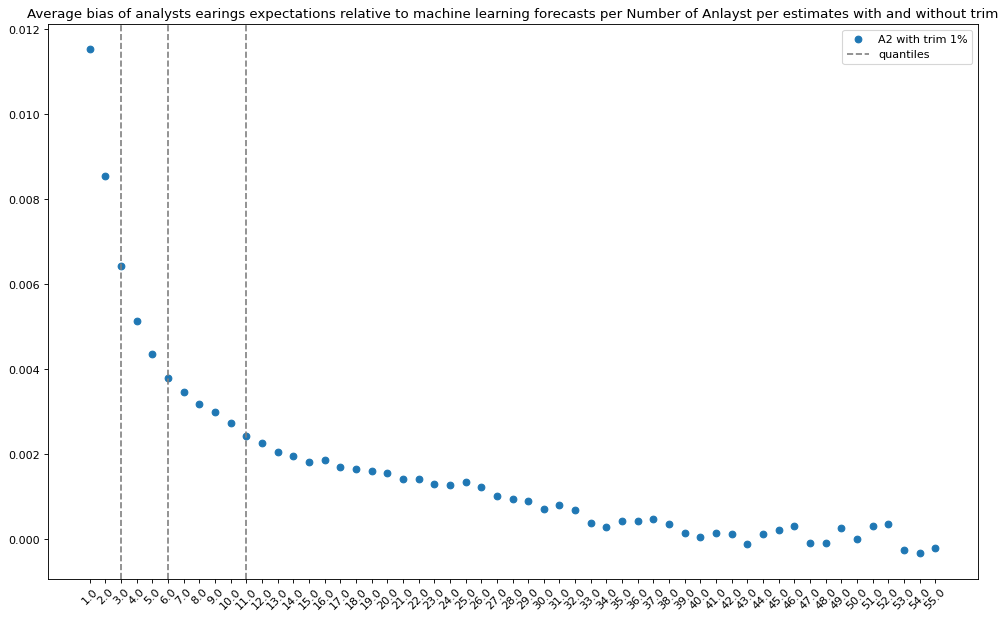

In [13]:
for period in periods: 
    plt.figure(figsize=(15, 9), dpi=80)
    df = data[period].copy()
    df.sort_values('numest', inplace=True)
    if period == 'A2' or period=='A1':
        df.bias_AF_ML = df.bias_AF_ML / 4
    #plt.scatter( df.numest.unique().astype(str), df.groupby(['numest']).bias_AF_ML.apply(lambda x: x.mean()), label=f'{period}'); #stats.trim_mean(x, 0.01)
    plt.scatter( df.numest.unique().astype(str), df.groupby(['numest']).bias_AF_ML.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period} with trim 1%'); 
    plt.axvline(df.numest.quantile(0.25), color='grey', linestyle='--', label='quantiles')
    plt.axvline(df.numest.quantile(0.5), color='grey', linestyle='--')
    plt.axvline(df.numest.quantile(0.75), color='grey', linestyle='--')
    plt.xticks(rotation=45)
    plt.legend()   
    plt.title('Average bias of analysts earings expectations relative to machine learning forecasts per Number of Anlayst per estimates with and without trim') 

#### We redo the bias timeseries analysis but consideirng differnet bis wrt to the number of analysts that build the forecast
#### Note: we focus on A1 and A2 forecats horizons

In [14]:
df_1 = pd.read_csv(f"results/A1_rf.csv")
df_2 = pd.read_csv(f"results/A2_rf.csv")
dictionary = {'A1': df_1, 'A2': df_2}


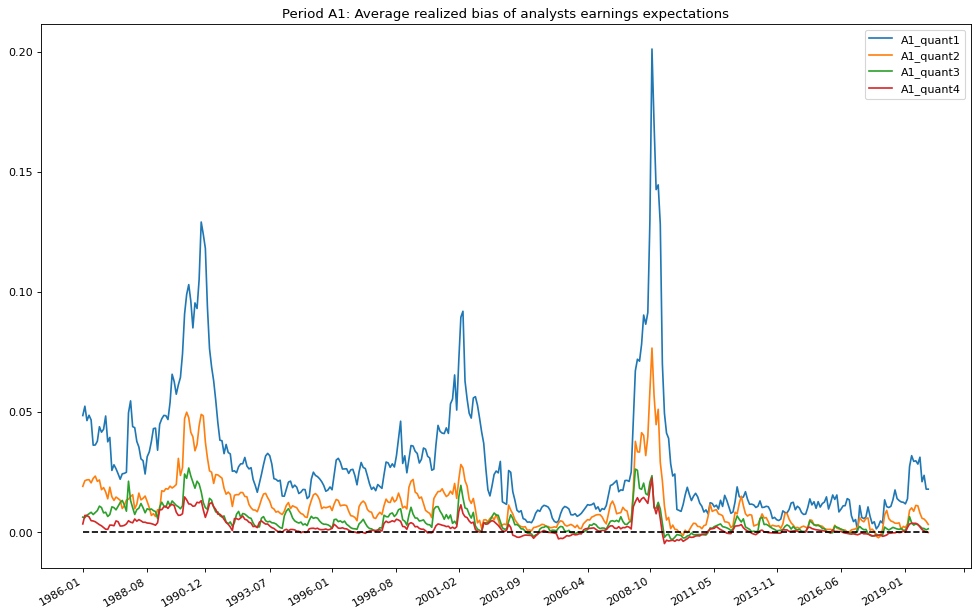

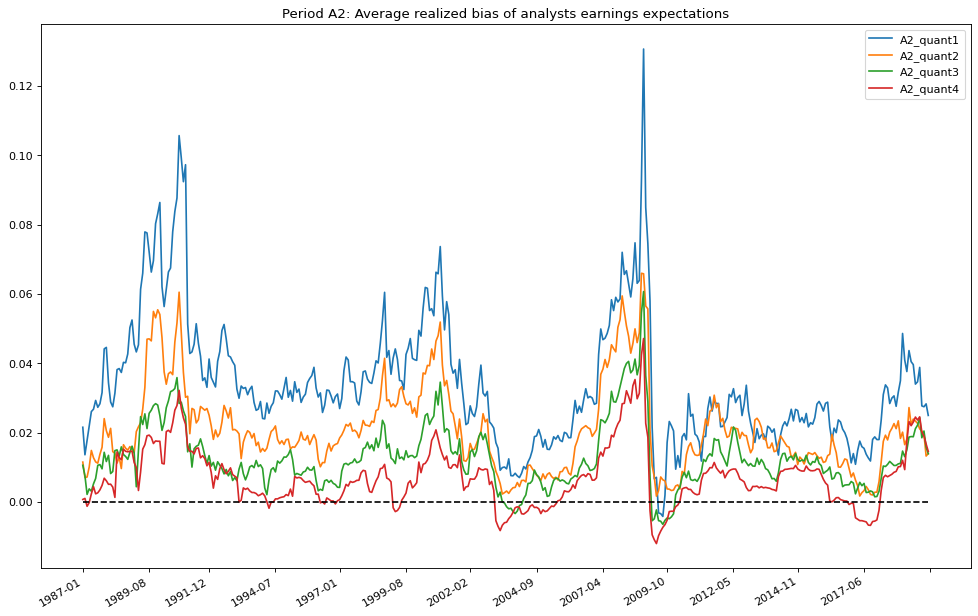

In [16]:
# NOT BIAS WE CARE (wrt to actual value)
for period, df in dictionary.items():
    plt.figure(figsize=(15, 10), dpi=80)
    df['bias_AF_AE'] = (df.meanest - df.adj_actual) / df.price
    df_trunc = df[df.numest <= df.numest.quantile(0.25)]
    plt.plot(df_trunc.Date.unique().astype(str), df_trunc.groupby(['Date']).bias_AF_AE.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period}_quant1');
    df_trunc = df[(df.numest > df.numest.quantile(0.25)) & (df.numest <= df.numest.quantile(0.5)) ]
    plt.plot(df_trunc.Date.unique().astype(str), df_trunc.groupby(['Date']).bias_AF_AE.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period}_quant2');
    df_trunc = df[(df.numest > df.numest.quantile(0.5)) & (df.numest <= df.numest.quantile(0.75)) ]
    plt.plot(df_trunc.Date.unique().astype(str), df_trunc.groupby(['Date']).bias_AF_AE.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period}_quant3');
    df_trunc = df[(df.numest > df.numest.quantile(0.75)) & (df.numest <= df.numest.quantile(1)) ]
    plt.plot(df_trunc.Date.unique().astype(str), df_trunc.groupby(['Date']).bias_AF_AE.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period}_quant4');
    locator = mdate.MonthLocator()
    plt.gca().xaxis.set_major_locator(locator)
    plt.gcf().autofmt_xdate()
    plt.hlines(0, min(df_trunc.Date.unique().astype(str)), max(df_trunc.Date.unique().astype(str)), 'black', linestyles='dashed')
    plt.legend()   
    plt.title(f'Period {period}: Average realized bias of analysts earnings expectations') 

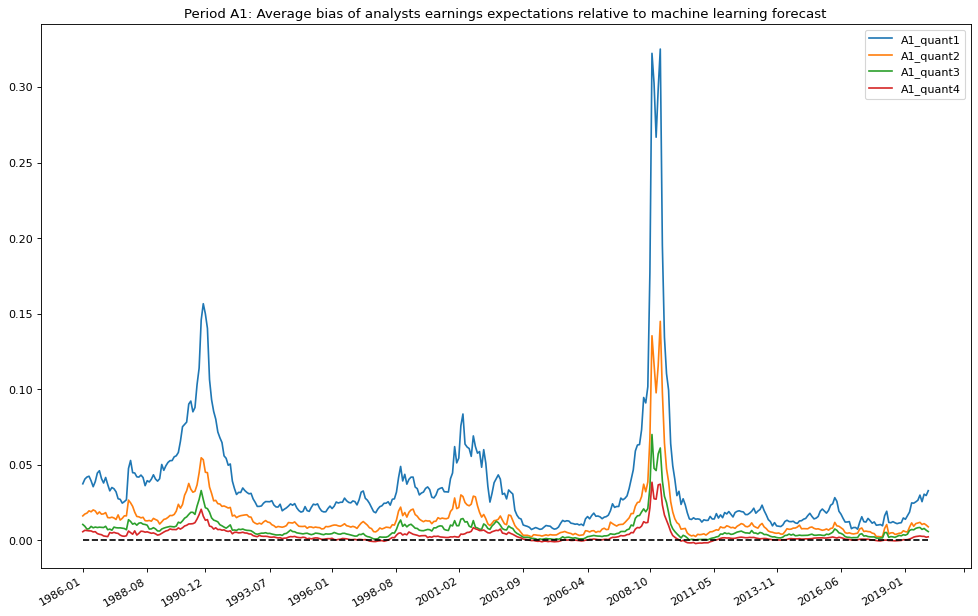

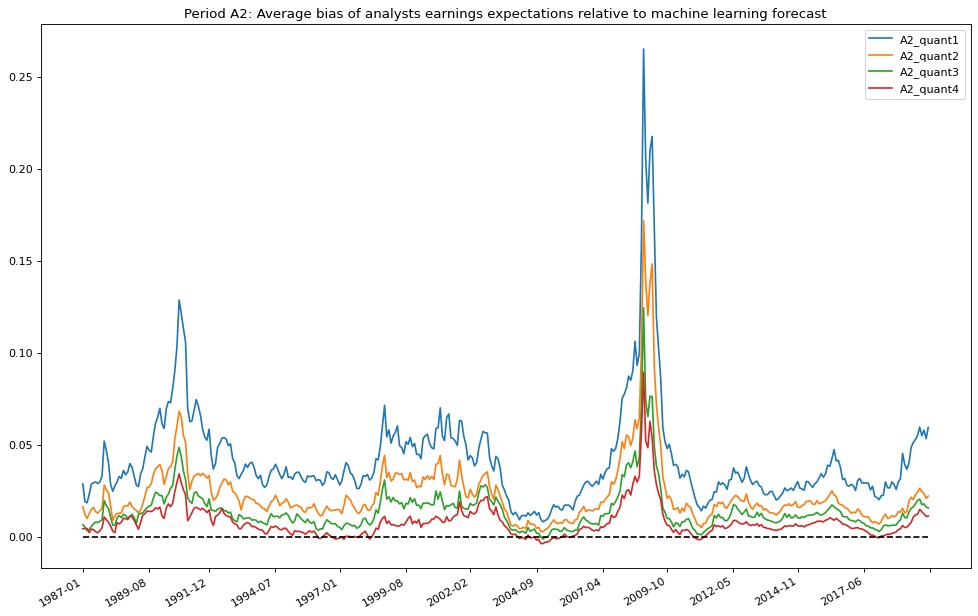

In [17]:
for period, df in dictionary.items():
    plt.figure(figsize=(15, 10), dpi=80)
    df_trunc = df[df.numest <= df.numest.quantile(0.25)]
    plt.plot(df_trunc.Date.unique().astype(str), df_trunc.groupby(['Date']).bias_AF_ML.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period}_quant1');
    df_trunc = df[(df.numest > df.numest.quantile(0.25)) & (df.numest <= df.numest.quantile(0.5)) ]
    plt.plot(df_trunc.Date.unique().astype(str), df_trunc.groupby(['Date']).bias_AF_ML.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period}_quant2');
    df_trunc = df[(df.numest > df.numest.quantile(0.5)) & (df.numest <= df.numest.quantile(0.75)) ]
    plt.plot(df_trunc.Date.unique().astype(str), df_trunc.groupby(['Date']).bias_AF_ML.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period}_quant3');
    df_trunc = df[(df.numest > df.numest.quantile(0.75)) & (df.numest <= df.numest.quantile(1)) ]
    plt.plot(df_trunc.Date.unique().astype(str), df_trunc.groupby(['Date']).bias_AF_ML.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period}_quant4');
    locator = mdate.MonthLocator()
    plt.gca().xaxis.set_major_locator(locator)
    plt.gcf().autofmt_xdate()
    plt.hlines(0, min(df_trunc.Date.unique().astype(str)), max(df_trunc.Date.unique().astype(str)), 'black', linestyles='dashed')
    plt.legend()   
    plt.title(f'Period {period}: Average bias of analysts earnings expectations relative to machine learning forecast') 

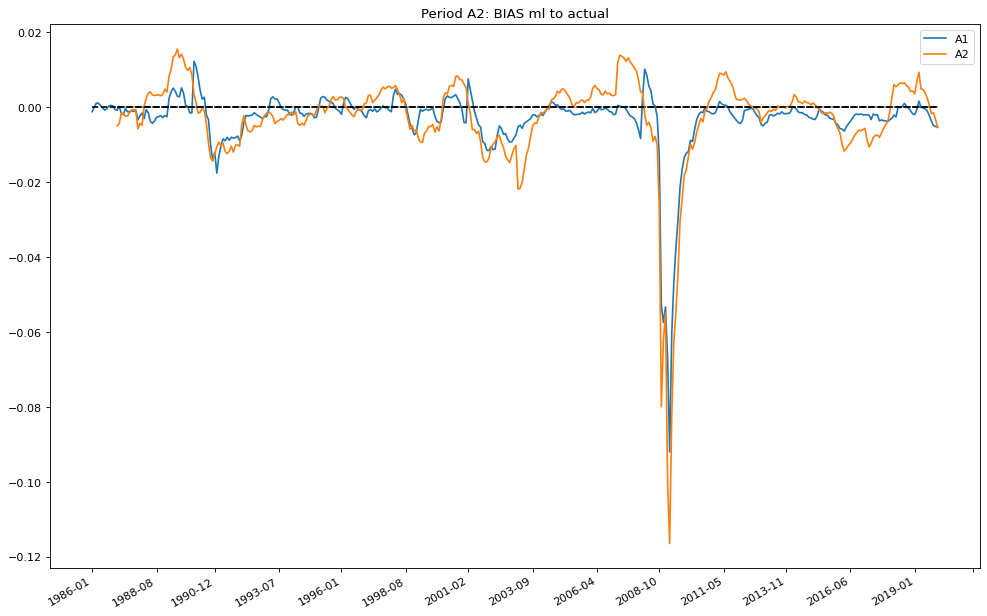

In [18]:
plt.figure(figsize=(15, 10), dpi=80)
for period, df in dictionary.items():
    df['bias_ML_AE'] = (df.predicted_adj_actual - df.adj_actual) / df.price
    plt.plot(df.Date.unique().astype(str), df.groupby(['Date']).bias_ML_AE.apply(lambda x: stats.trim_mean(x, 0.01)), label=f'{period}');
    locator = mdate.MonthLocator()
    plt.gca().xaxis.set_major_locator(locator)
    plt.gcf().autofmt_xdate()
    plt.hlines(0, min(df.Date.unique().astype(str)), max(df.Date.unique().astype(str)), 'black', linestyles='dashed')
    plt.legend()   
    plt.title(f'Period {period}: BIAS ml to actual') 

## Regulation nov 2000 - Reg FD

In [19]:
def compute_bias_results ( period):
    df = data[period]
    df_pre = df[df.Date<= '2000-10']
    df_post = df[df.Date>'2000-10']
    bias_analyst_ml_pre = df_pre.bias_AF_ML.mean()
    bias_analyst_actual_pre = ((df_pre.meanest - df_pre.adj_actual) / df_pre.price).mean()

    bias_analyst_ml_post =df_post.bias_AF_ML.mean()
    bias_analyst_actual_post = ((df_post.meanest - df_post.adj_actual) / df_post.price).mean()

    return {'value': period, 'Bias AF-AE pre 2000':round(bias_analyst_actual_pre, 3), 'Bias AF-AE post 2000':round(bias_analyst_actual_post, 3),
     'Bias AF-RF value pre 2000':round(bias_analyst_ml_pre, 3), 'Bias AF-RF post 2000':round(bias_analyst_ml_post, 3),'N pre 2000':len(df_pre), 'N post 2000':len(df_post) }
  

In [20]:
# Create an empty dictionary to store DataFrames
results = []

for period in ['A1', 'A2']:
    results.append(compute_bias_results(period))

In [21]:
display(pd.DataFrame(results).set_index('value').rename_axis(None))

,Bias AF-AE pre 2000,Bias AF-AE post 2000,Bias AF-RF value pre 2000,Bias AF-RF post 2000,N pre 2000,N post 2000
A1,0.023,0.013,0.019,0.014,377048,536003
A2,0.029,0.017,0.028,0.022,296802,478359


In [22]:
data['A1']['pre_regulation'] = np.where(data['A1'].Date<= '2000-10', 1,0 )
(data['A1'].groupby("pre_regulation")['bias_AF_ML']).describe()

,count,mean,std,min,25%,50%,75%,max
pre_regulation,,,,,,,,
0,536003.0,0.014476,0.145343,-19.366896,-0.000719,0.001170,0.008173,25.775534
1,377048.0,0.018980,0.090217,-5.875864,-0.000194,0.003692,0.015710,15.705994


In [23]:
data['A2']['pre_regulation'] = np.where(data['A2'].Date<= '2000-10', 1,0 )
(data['A2'].groupby("pre_regulation")['bias_AF_ML']).describe()


,count,mean,std,min,25%,50%,75%,max
pre_regulation,,,,,,,,
0,478359.0,0.021558,0.082681,-7.571120,0.000121,0.007053,0.022328,11.966144
1,296802.0,0.027752,0.066243,-1.466344,-0.002690,0.011287,0.037957,5.084308


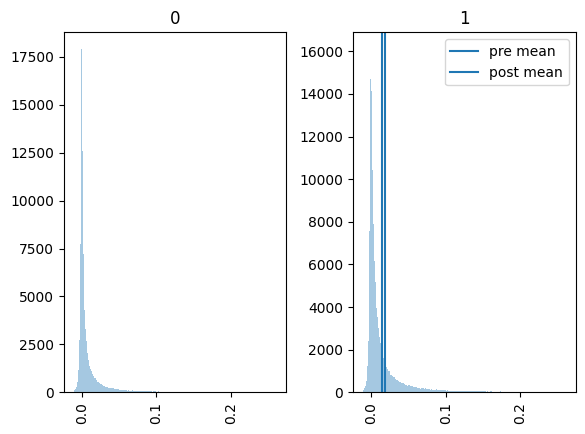

In [24]:
lower_percentile = np.percentile(data['A1']['bias_AF_ML'], 1)
upper_percentile = np.percentile(data['A1']['bias_AF_ML'], 99)

# Trim data
trimmed_data_A1 = data['A1'][(data['A1']['bias_AF_ML'] >= lower_percentile) & (data['A1']['bias_AF_ML'] <= upper_percentile)]
colors= ['r', 'b']
labels = ['post', 'pre']
trimmed_data_A1.hist('bias_AF_ML', alpha=0.4,by='pre_regulation', bins='auto')
plt.axvline(data['A1'][data['A1'].pre_regulation==1]['bias_AF_ML'].mean(), label='pre mean')
plt.axvline(data['A1'][data['A1'].pre_regulation==0]['bias_AF_ML'].mean(), label='post mean')
plt.legend()


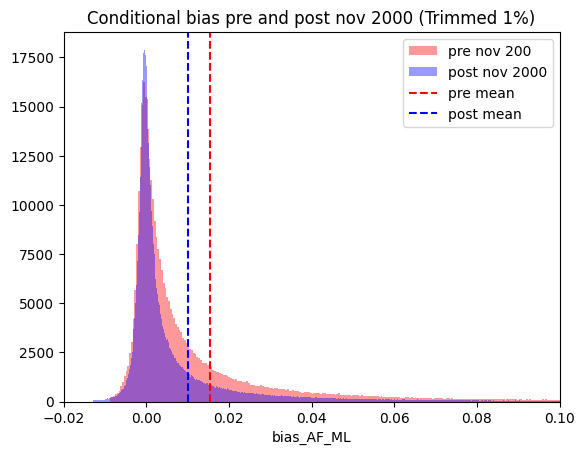

In [25]:

# Create filters for pre_regulation groups
pre_regulation_A1 = data['A1'][data['A1']['pre_regulation'] == 1]['bias_AF_ML']
post_regulation_A1 = data['A1'][data['A1']['pre_regulation'] == 0]['bias_AF_ML']

# Trim data for each group (trimming 1% from both ends)
trim_percent = 1
lower_percentile_A1 = np.percentile(pre_regulation_A1, trim_percent)
upper_percentile_A1 = np.percentile(pre_regulation_A1, 100 - trim_percent)
trimmed_pre_regulation_A1 = pre_regulation_A1[(pre_regulation_A1 >= lower_percentile_A1) & (pre_regulation_A1 <= upper_percentile_A1)]

lower_percentile_post = np.percentile(post_regulation_A1, trim_percent)
upper_percentile_post = np.percentile(post_regulation_A1, 100 - trim_percent)
trimmed_post_regulation_A1 = post_regulation_A1[(post_regulation_A1 >= lower_percentile_post) & (post_regulation_A1 <= upper_percentile_post)]

# Plot histograms for each group
plt.hist(trimmed_pre_regulation_A1, alpha=0.4, bins='auto', color='red', label='pre nov 200')
plt.hist(trimmed_post_regulation_A1, alpha=0.4, bins='auto', color='blue', label='post nov 2000')

# Plot mean lines for each group
plt.axvline(trimmed_pre_regulation_A1.mean(), color='red', linestyle='--', label='pre mean')
plt.axvline(trimmed_post_regulation_A1.mean(), color='blue', linestyle='--', label='post mean')

plt.legend()
plt.xlabel('bias_AF_ML')
plt.title('Conditional bias pre and post nov 2000 (Trimmed 1%)')
plt.xlim(-0.02, 0.10)
plt.show()





## Bias and Error

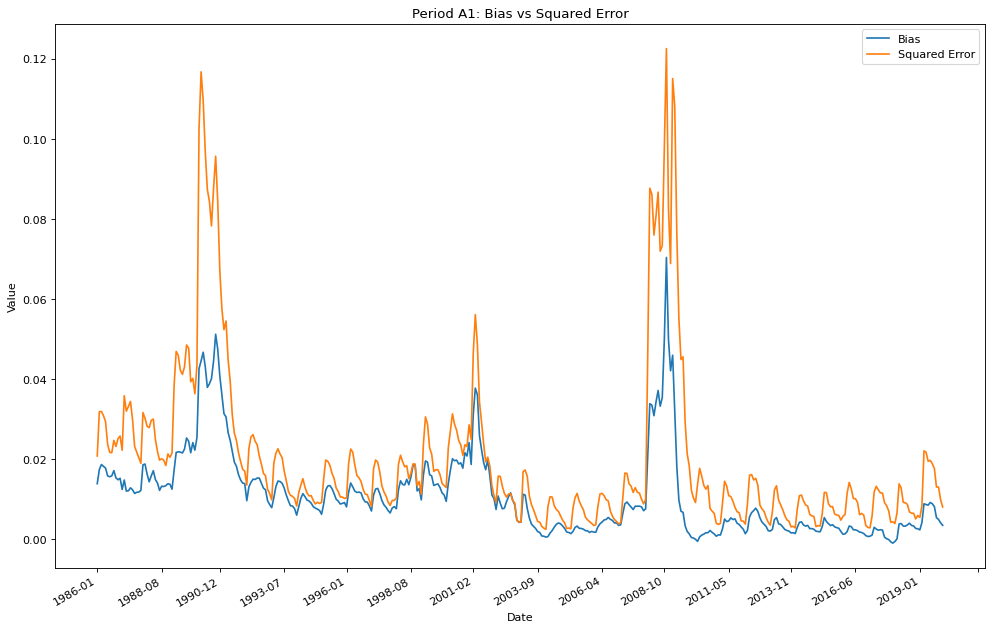

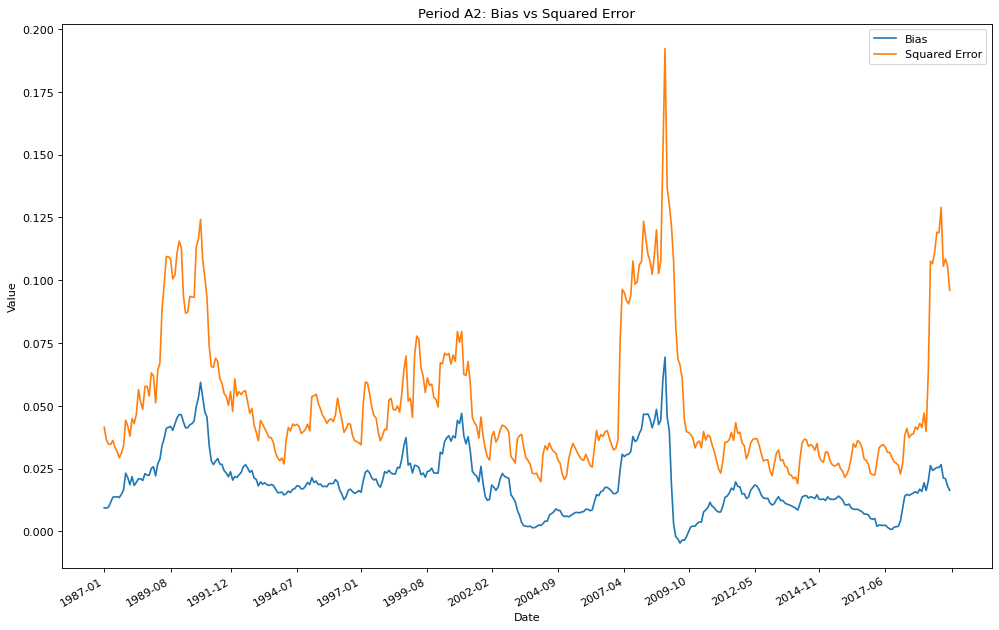

In [26]:

for period, df in dictionary.items():
    plt.figure(figsize=(15, 10), dpi=80)
    
    # Calculate bias
    df['bias_analyst_actual'] = (df['meanest'] - df['adj_actual']) / df['price']
    
    # Calculate squared error
    df['squared_error'] = ((df['meanest'] - df['adj_actual']) ** 2) / df['price']
    
    # Group by date and calculate trimmed mean bias and squared error
    df_grouped = df.groupby('Date').agg({'bias_analyst_actual': lambda x: stats.trim_mean(x, 0.01),
                                         'squared_error': lambda x: stats.trim_mean(x, 0.01)})
    
    # Plot bias against squared error
    plt.plot(df_grouped.index.astype(str), df_grouped['bias_analyst_actual'], label='Bias')
    plt.plot(df_grouped.index.astype(str), df_grouped['squared_error'], label='Squared Error')
    
    # Set x-axis to display months and rotate labels
    locator = mdate.MonthLocator()
    plt.gca().xaxis.set_major_locator(locator)
    plt.gcf().autofmt_xdate()
    
    # Add legend and title
    plt.legend()
    plt.title(f'Period {period}: Bias vs Squared Error')
    plt.xlabel('Date')
    plt.ylabel('Value')
    
    plt.show()


20 points are 0.0 % data
20 points are 0.0 % data


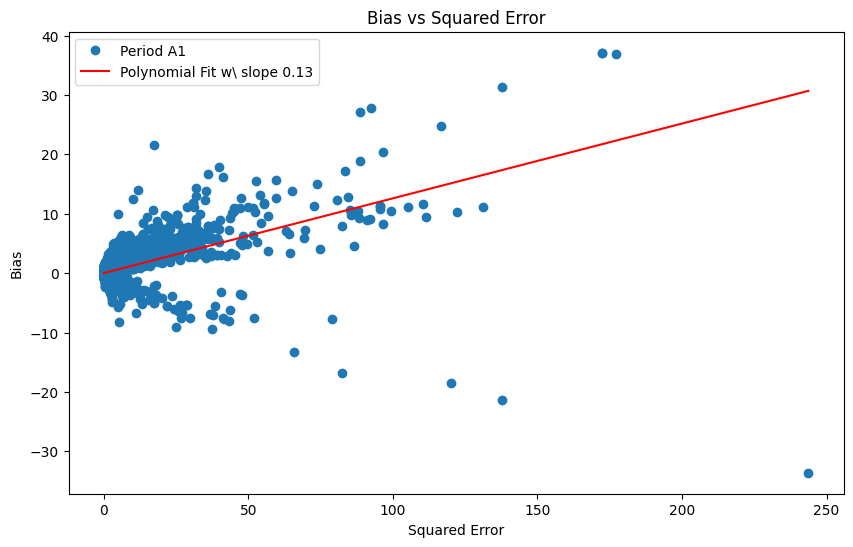

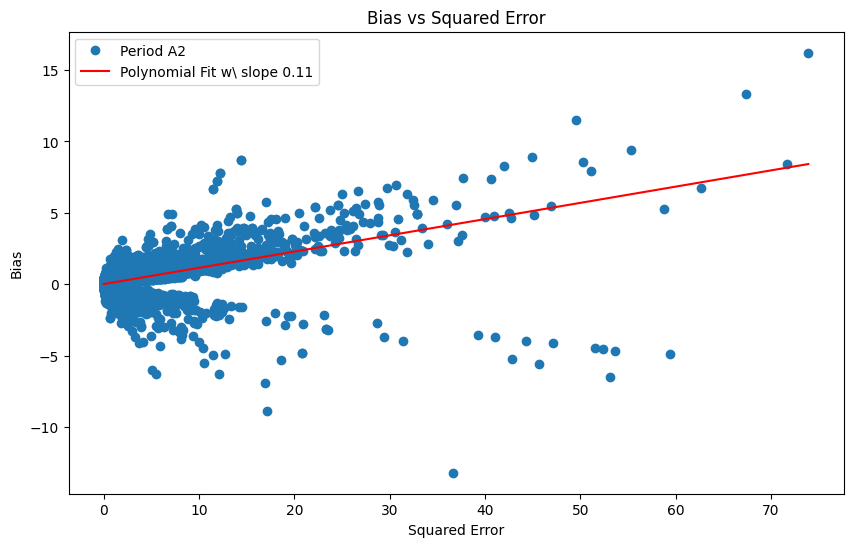

In [27]:
# CASE 1  where evry comapny- every date is a point

for period, df in dictionary.items():
    plt.figure(figsize=(10, 6))
    
    # Calculate bias
    df['bias_analyst_actual'] = (df['meanest'] - df['adj_actual']) / df['price']
    
    # Calculate squared error
    df['squared_error'] = ((df['meanest'] - df['adj_actual']) ** 2) / df['price']

    # Group by date and calculate trimmed mean bias and squared error
    df_grouped = df.copy()

    # Sort DataFrame by squared error
    print(f'20 points are {np.round(20/df_grouped.shape[0]*100, 1)} % data')
    df_sorted = df_grouped.sort_values(by='squared_error')[5:-5]
    
    # Fit a polynomial
    coeffs = np.polyfit(df_sorted['squared_error'], df_sorted['bias_analyst_actual'], 1)
    poly = np.poly1d(coeffs) 
    
    # Plot bias against sorted squared error sequence
    plt.plot(df_sorted['squared_error'], df_sorted['bias_analyst_actual'], 'o', label=f'Period {period}')
    
    # Plot polynomial fit
    plt.plot(df_sorted['squared_error'], poly(df_sorted['squared_error']), label=f'Polynomial Fit w\ slope {np.round(coeffs[0], 2)}', color='red')
    
    # Add legend and labels
    plt.legend()
    plt.title('Bias vs Squared Error')
    plt.xlabel('Squared Error')
    plt.ylabel('Bias')
    
plt.show()


5 points are 1.2 % data
5 points are 1.3 % data


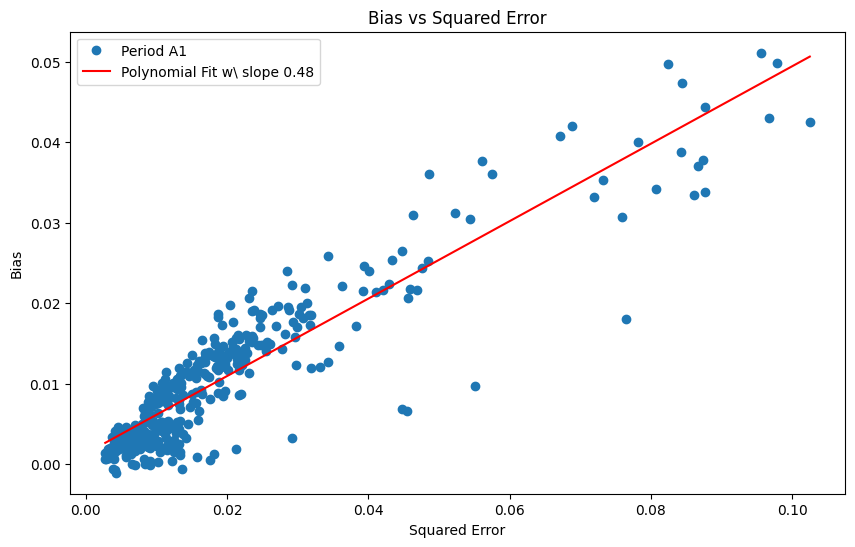

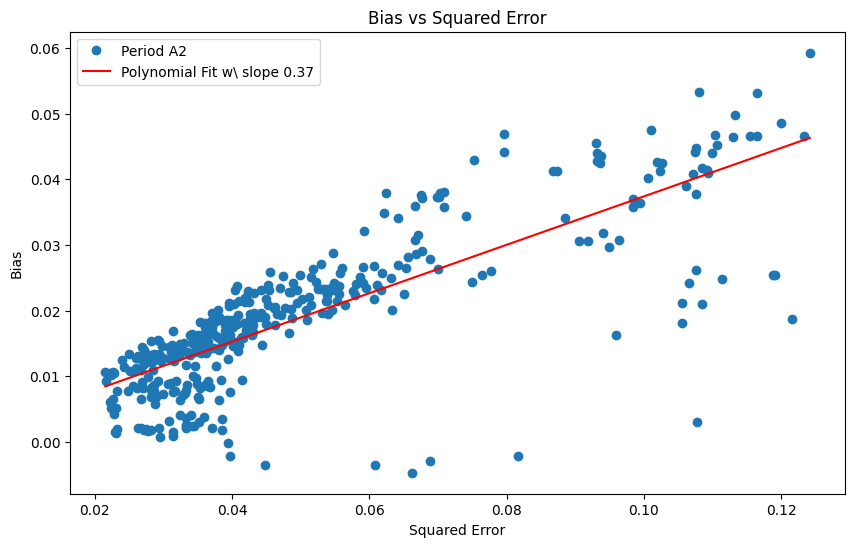

In [28]:
# CASE 2 where we group by date before
for period, df in dictionary.items():
    plt.figure(figsize=(10, 6))
    
    # Calculate bias
    df['bias_analyst_actual'] = (df['meanest'] - df['adj_actual']) / df['price']
    
    # Calculate squared error
    df['squared_error'] = ((df['meanest'] - df['adj_actual']) ** 2) / df['price']

    # Group by date and calculate trimmed mean bias and squared error
    df_grouped = df.groupby('Date').agg({'bias_analyst_actual': lambda x: stats.trim_mean(x, 0.01),
                                         'squared_error': lambda x: stats.trim_mean(x, 0.01)})

    # Sort DataFrame by squared error
    print(f'5 points are {np.round(5/df_grouped.shape[0]*100, 1)} % data')
    df_sorted = df_grouped.sort_values(by='squared_error')[5:-5]
    
    # Fit a polynomial
    coeffs = np.polyfit(df_sorted['squared_error'], df_sorted['bias_analyst_actual'], 1)
    poly = np.poly1d(coeffs) 
    
    # Plot bias against sorted squared error sequence
    plt.plot(df_sorted['squared_error'], df_sorted['bias_analyst_actual'], 'o', label=f'Period {period}')
    
    # Plot polynomial fit
    plt.plot(df_sorted['squared_error'], poly(df_sorted['squared_error']), label=f'Polynomial Fit w\ slope {np.round(coeffs[0], 2)}', color='red')
    
    # Add legend and labels
    plt.legend()
    plt.title('Bias vs Squared Error')
    plt.xlabel('Squared Error')
    plt.ylabel('Bias')
    
plt.show()


5 points are 1.2 % data


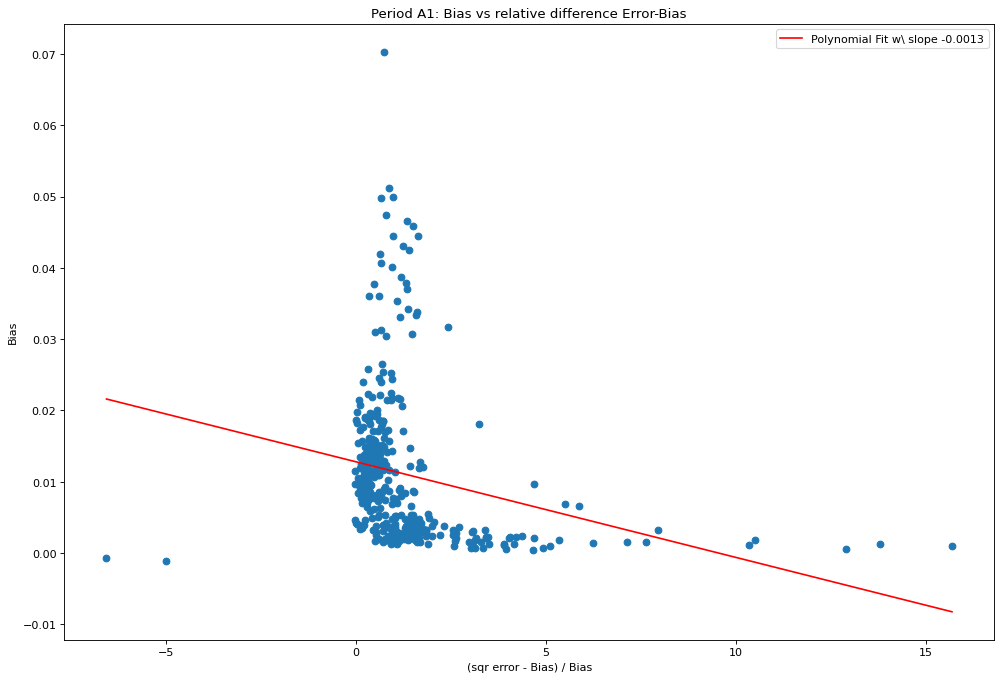

5 points are 1.3 % data


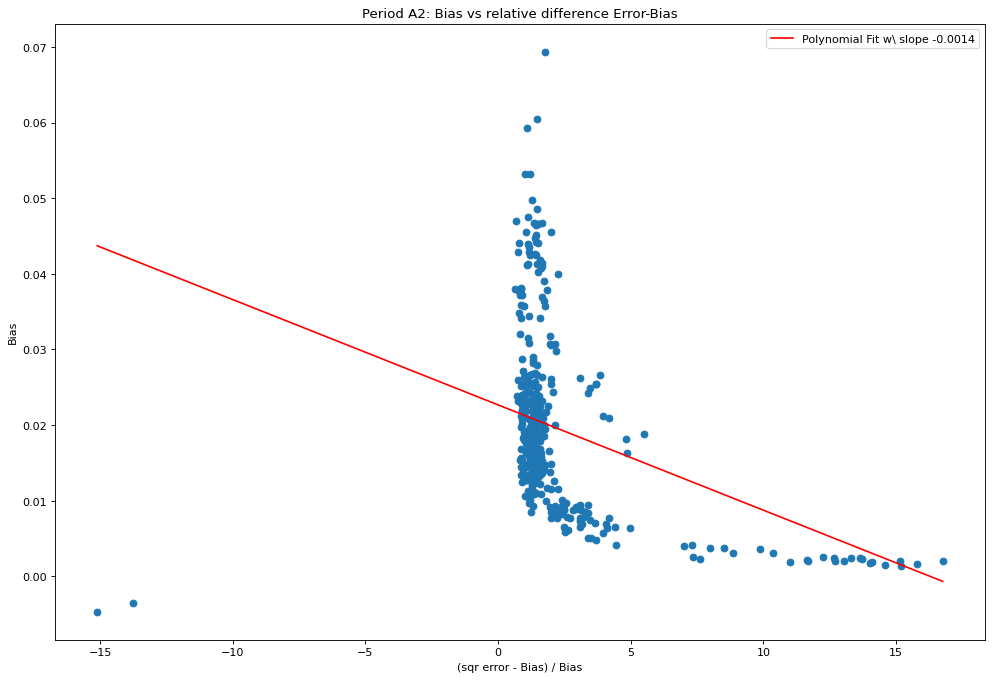

In [29]:
# CASE 3 consider relative measure
for period, df in dictionary.items():
    plt.figure(figsize=(15, 10), dpi=80)
    
    
    # Group by date and calculate trimmed mean bias and squared error
    df_grouped = df.groupby('Date').agg({'bias_analyst_actual': lambda x: stats.trim_mean(x, 0.01),
                                        'squared_error': lambda x: stats.trim_mean(x, 0.01)})
 
    df_grouped['err_minus_bias_rel'] = ((df_grouped['squared_error'] - df_grouped['bias_analyst_actual']) / df_grouped['bias_analyst_actual'])
    df_grouped['err_minus_bias_rel']  = np.where(df_grouped['bias_analyst_actual']==0, (df_grouped['squared_error'] - df_grouped['bias_analyst_actual']), df_grouped['err_minus_bias_rel'])
    
    print(f'5 points are {np.round(5/df_grouped.shape[0]*100, 1)} % data')
    df_grouped = df_grouped.sort_values(by='err_minus_bias_rel')[5:-5]

    
    # Fit a polynomial
    coeffs = np.polyfit(df_grouped['err_minus_bias_rel'], df_grouped['bias_analyst_actual'], 1)
    poly = np.poly1d(coeffs)

    plt.scatter( df_grouped['err_minus_bias_rel']  , df_grouped['bias_analyst_actual'])
    
    # Plot polynomial fit
    plt.plot(df_grouped['err_minus_bias_rel'], poly(df_grouped['err_minus_bias_rel']), label=f'Polynomial Fit w\ slope {np.round(coeffs[0], 4)}', color='red')

    # Add legend and title
    plt.legend()
    plt.title(f'Period {period}: Bias vs relative difference Error-Bias')
    plt.xlabel('(sqr error - Bias) / Bias')
    plt.ylabel('Bias')
    #plt.xlim((0,25))
    #plt.ylim((-5,5))




    
    plt.show()


In [30]:
df_1['high_bias'] = 1*(df_1.bias_analyst_actual>=df_1.bias_analyst_actual.median())

,count,mean,std,min,25%,50%,75%,max
high_bias,,,,,,,,
0,433132.0,8.160699,7.319692,1.0,3.0,6.0,11.0,56.0
1,479919.0,7.029790,6.759289,1.0,2.0,5.0,9.0,56.0


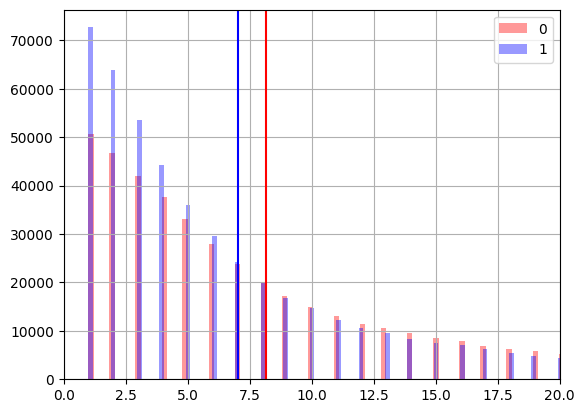

In [31]:
fig,ax = plt.subplots()
colors= ['r', 'b']
for (i, d) in df_1.groupby('high_bias'):
    d['numest'].hist(alpha=0.4, ax=ax, label=i, bins='auto', color=colors[i])
    plt.axvline(d['numest'].mean(),  color=colors[i])
ax.legend()
ax.set_xlim(0,20)
(df_1.groupby("high_bias")['numest']).describe()

,count,mean,std,min,25%,50%,75%,max
high_bias,,,,,,,,
0,433132.0,1.160060,1.601493,-9.98,0.33,0.90,1.75,9.97
1,479919.0,0.976841,1.487691,-9.94,0.22,0.75,1.54,9.99


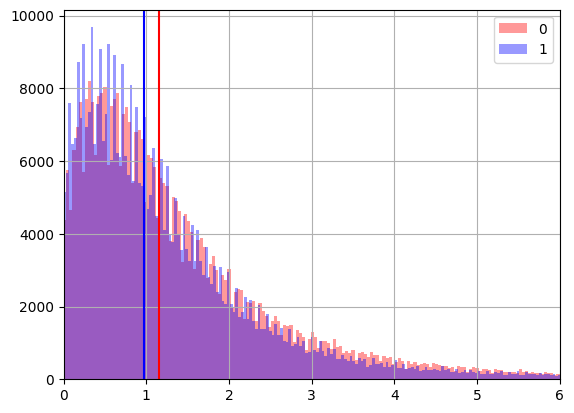

In [32]:
fig,ax = plt.subplots()
colors= ['r', 'b']
for (i, d) in df_1.groupby('high_bias'):
    d['meanest'].hist(alpha=0.4, ax=ax, label=i, bins='auto', color=colors[i])
    plt.axvline(d['meanest'].mean(),  color=colors[i])
ax.legend()
ax.set_xlim(0,6)

(df_1.groupby("high_bias")['meanest']).describe()

,count,mean,std,min,25%,50%,75%,max
high_bias,,,,,,,,
0,433132.0,31.035956,34.056335,0.080,12.9,23.58,39.500,1944.30005
1,479919.0,23.130141,26.764125,0.026,8.5,16.75,29.625,1977.90002


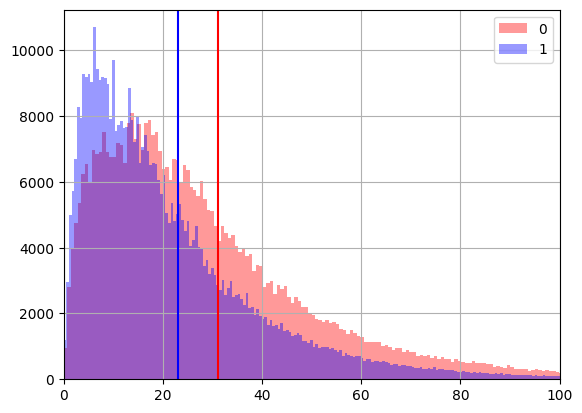

In [33]:
fig,ax = plt.subplots()
colors= ['r', 'b']
for (i, d) in df_1.groupby('high_bias'):
    d['price'].hist(alpha=0.4, ax=ax, label=i, bins='auto', color=colors[i])
    plt.axvline(d['price'].mean(),  color=colors[i])
ax.legend()
ax.set_xlim(0,100)
(df_1.groupby("high_bias")['price']).describe()

,count,mean,std,min,25%,50%,75%,max
high_bias,,,,,,,,
0,433132.0,0.421229,0.815788,-9.95,0.08,0.26,0.58,9.99
1,479919.0,0.321731,0.840668,-9.94,0.02,0.19,0.48,9.92


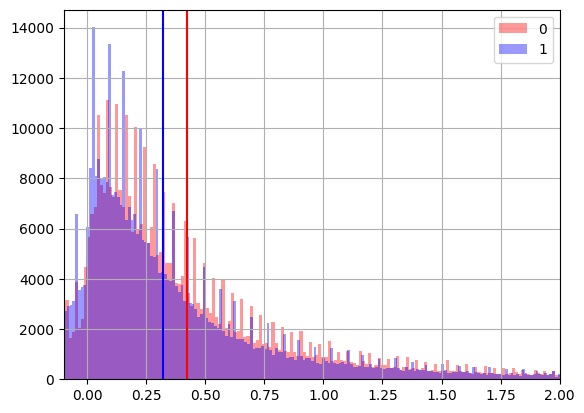

In [34]:
fig,ax = plt.subplots()
colors= ['r', 'b']
for (i, d) in df_1.groupby('high_bias'):
    d['adj_past_eps'].hist(alpha=0.4, ax=ax, label=i, bins='auto', color=colors[i])
    plt.axvline(d['adj_past_eps'].mean(),  color=colors[i])
ax.legend()
ax.set_xlim(-0.1,2)
(df_1.groupby("high_bias")['adj_past_eps']).describe()